In [1]:
%matplotlib notebook

In [1]:
from importlib import reload
from two_transmons import Rabi
reload(Rabi)
from two_transmons.Rabi import *
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time
import numpy as np
from numpy import dot

## Quantum Process Tomography

In [2]:
Nc = 7
N_trunc = 3
Ec1 = 0.25 * 2 * np.pi
Ec2 = 1.03*Ec1
Ecc = 0.01/1.2**2 * 2 * np.pi/5 # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 5e6, 1e6

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, N_trunc, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, N_trunc, 2)
dts = DoubleTransmonSystem(tr1, tr2, Ecc)
r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)


freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
Ts = linspace(0, params["finish"], params['t_points'])
T = Tomography(dts, Ts, params, r)

#print(params)

/tmp/ipykernel_1403764/3955379896.py:23: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  Ts = linspace(0, params["finish"], params['t_points'])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### Our gate in bloch sphere

In [3]:
dm = T.run_iswap_test_step_parallel([(T._pi_duration/2, 0),(0,0)], full_output = True)

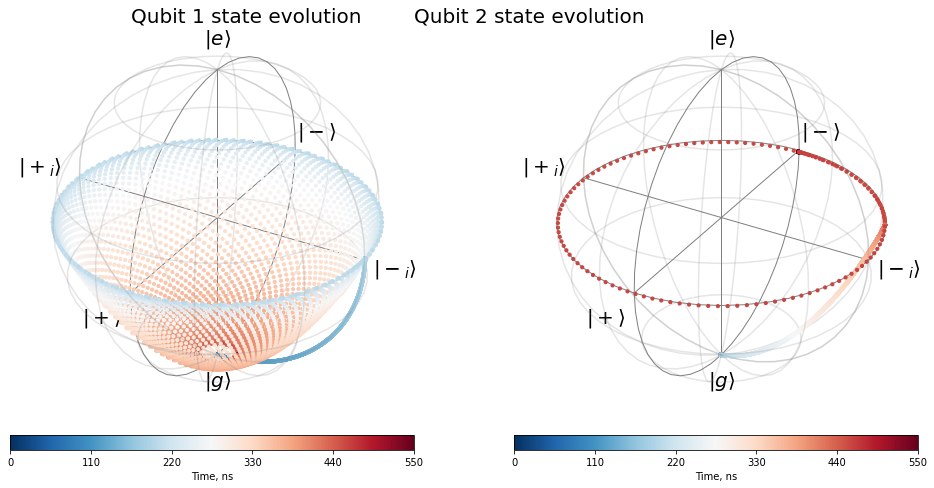

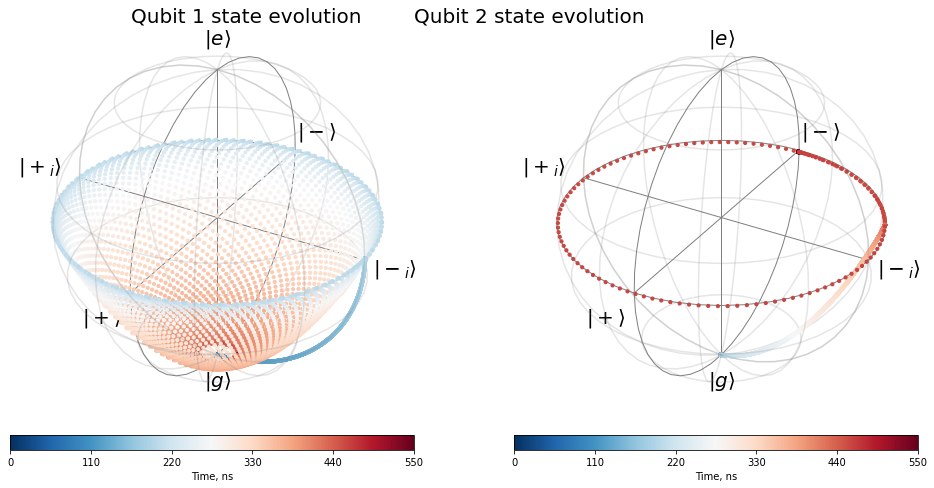

In [4]:
Tomography.plot_qubits_dynamic(T,10, dm=dm.states, interaction = True)

### $ \mid-i\rangle\otimes\mid1\rangle \rightarrow\mid1\rangle\otimes\mid + \rangle$

In [5]:
dm = T.run_iswap_test_step_parallel([(T._pi_duration/2, 0),(T._pi_duration,0)], full_output = True)

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


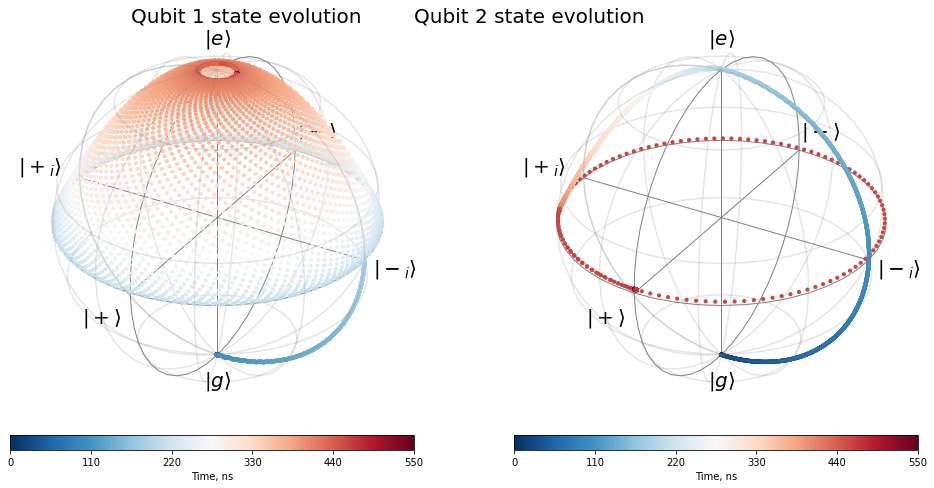

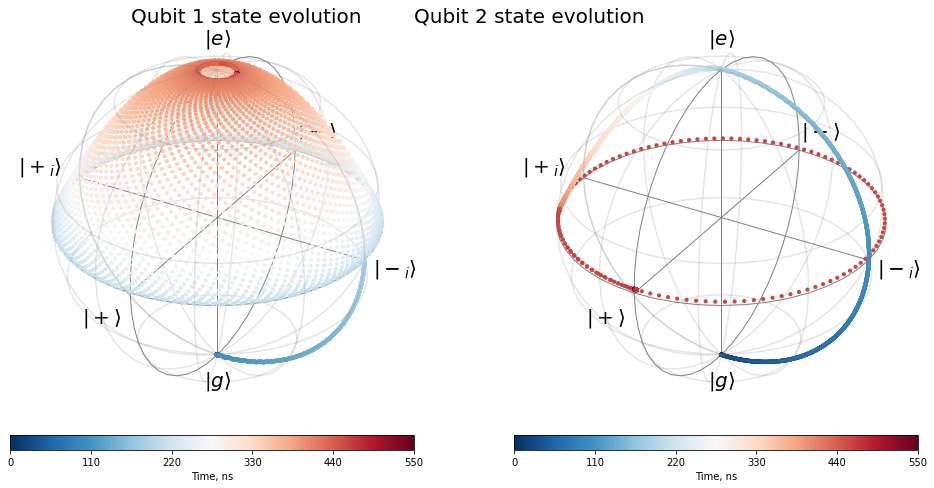

In [6]:
Tomography.plot_qubits_dynamic(T,10, dm=dm.states, interaction = True)

In [ ]:
T._c_ops =[] #T._dts.c_ops(0, 1 / 2)
dm, dm_final = T.run_2iswap_step_parallel([(T._pi_duration/2, 0),(T._pi_duration,0)], full_output = True)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
Tomography.plot_qubits_dynamic(T,10, dm=dm, interaction = True)

In [10]:
T._2q_rotations[15]

((83.625, 0), (83.625, 3.141592653589793))

### Визуальное сравнение предсказанной матрицы и матрицы для идеального i-swap

In [3]:
T._c_ops = [] #T._dts.c_ops(0, 1 / 2)
rho_predicted, rho_ideal = T.find_iswap_rotation_matrix(15)

state fidelity = (0.9958990005015986-1.6936179350269679e-15j)


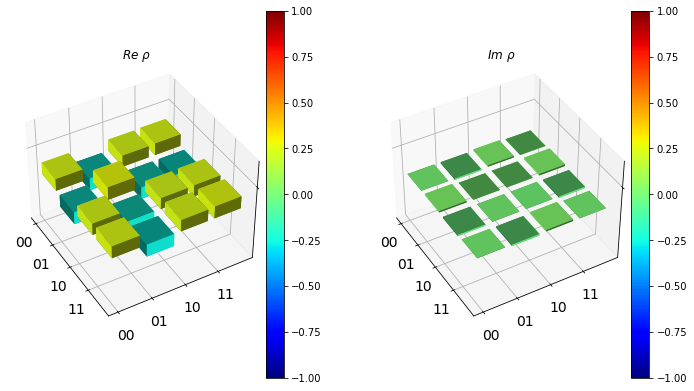

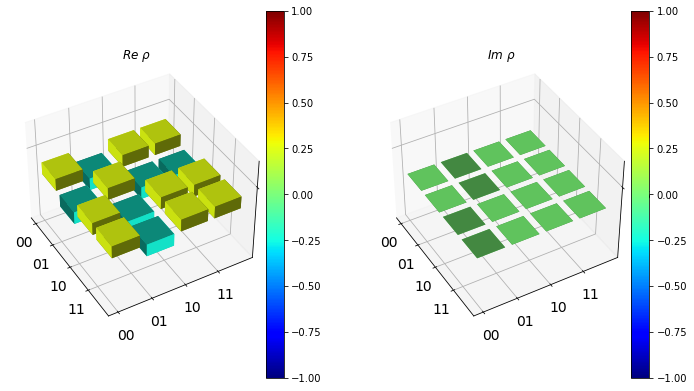

In [4]:
Tomography.show_density_matrix(rho_predicted)
Tomography.show_density_matrix(rho_ideal)
fidelity = Tomography.state_fidelity(rho_ideal, rho_predicted)
print ('state fidelity =', fidelity)

### $ \mid0\rangle\otimes\mid+i\rangle \rightarrow\mid-\rangle\otimes\mid 0 \rangle$

In [10]:
#T._c_ops = T._dts.c_ops(0, 1 / 2)
dm = T.run_iswap_test_step_parallel([(0, 0),(T._pi_duration/2,0)], full_output = True)


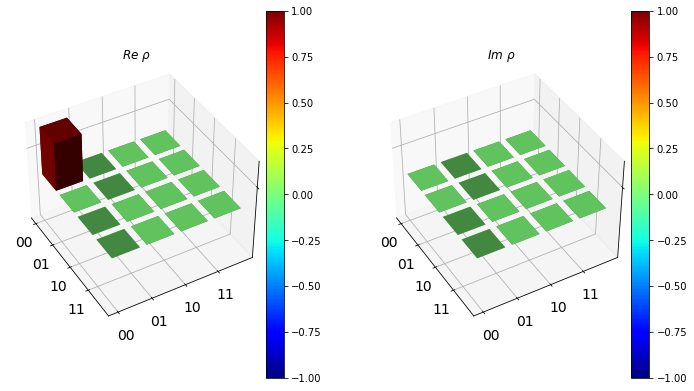

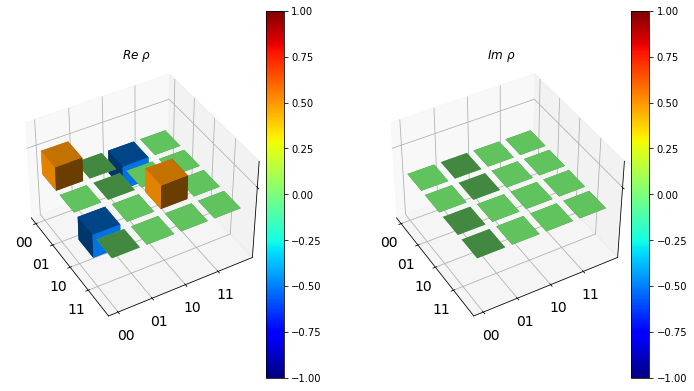

In [11]:
#rho_predicted = Tomography._find_rho_iswap(T,10,dm_final)
Tomography.show_density_matrix(Tomography.rho3dim_to_rho(dm.states[-1]))
rho_ideal = [[1/2,0,-1/2,0],[0,0,0,0],[-1/2,0,1/2,0],[0,0,0,0]]
Tomography.show_density_matrix(rho_ideal)

### $ \mid0\rangle\otimes\mid-\rangle \rightarrow \mid-i\rangle\otimes\mid 0 \rangle$

In [3]:
T._c_ops = []
dm = T.run_iswap_test_step_parallel([(0, 0),(T._pi_duration/2,pi/2)], iswap2= False, full_output = True).states

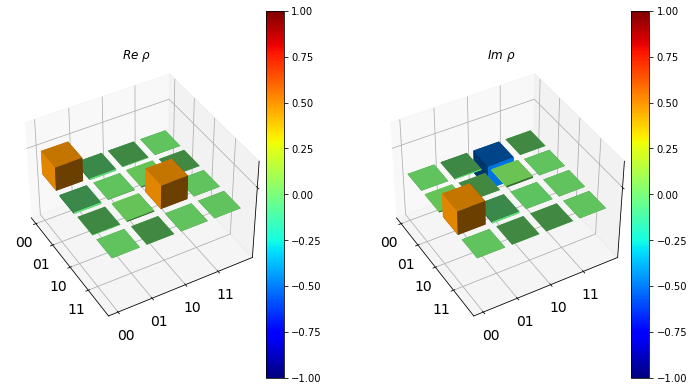

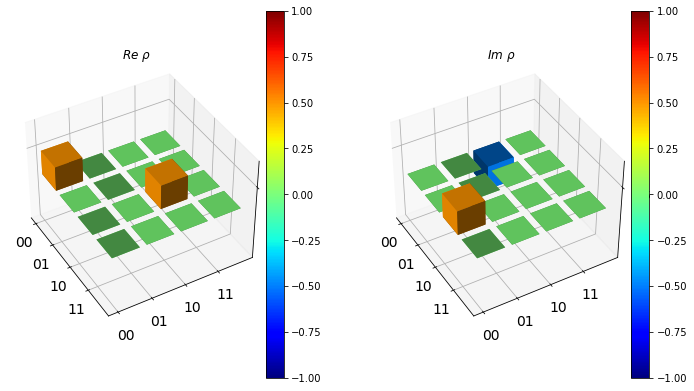

In [5]:
#rho_predicted = Tomography._find_rho_iswap(T,10,dm_final)
rho_predicted = Tomography.rho3dim_to_rho(dm[-1])
Tomography.show_density_matrix(Tomography.rho3dim_to_rho(dm[-1]))
rho_ideal = [[1/2,0,-1j/2,0],[0,0,0,0],[1j/2,0,1/2,0],[0,0,0,0]]
Tomography.show_density_matrix(rho_ideal)


## Launching a large series of experiments

In [5]:
T.run_iswap_test(iswap2 = False, num_cpus = 24)
#T.run_2iswap( num_cpus = 24)
#T.run_4iswap(num_cpus = 24)
#T.run_iswap(num_cpus = 12)

  0%|          | 0/36 [00:00<?, ?it/s]

In [6]:
max_iter = 200
start = time.time()
#chi_tomo = T.process_tomo(2,max_iter)
chi_tomo = T.process_tomo(1,max_iter,test=True)
#chi_tomo = T.process_tomo(1,max_iter,iswap4=True)
finish = time.time()
print (finish - start, 's for optimization with', max_iter, 'iterations' )

Tomography iswap_operator: Likelihood minimization:   0%|                                                     …

error is 0.17880685211859332
280.8867218494415 s for optimization with 200 iterations


## Pauli transfer matrix

### Simulation

/tmp/ipykernel_1333491/3524721834.py:2: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  R_tomo_re = real (R_tomo)
/tmp/ipykernel_1333491/3524721834.py:3: DeprecationWarning: scipy.imag is deprecated and will be removed in SciPy 2.0.0, use numpy.imag instead
  R_tomo_im = imag (R_tomo)


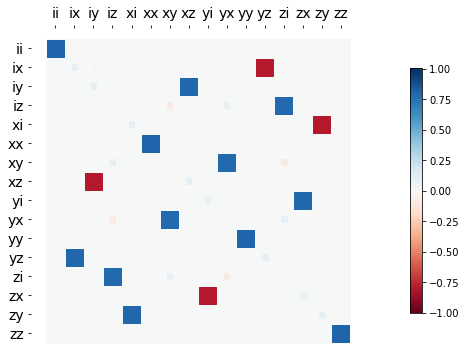

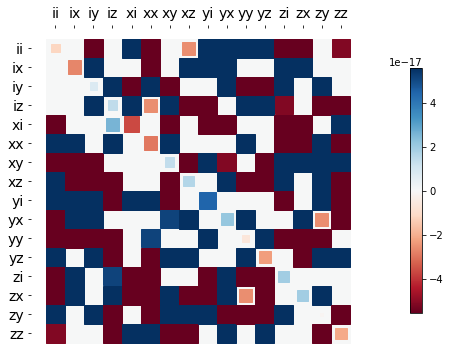

In [34]:
R_tomo = Tomography.chi_to_R(T,chi_tomo)
R_tomo_re = real (R_tomo)
R_tomo_im = imag (R_tomo)
xlabels = ['ii','ix','iy','iz','xi','xx','xy','xz','yi','yx','yy','yz','zi','zx','zy','zz']
ylabels = xlabels
fig,ax = hinton (R_tomo_re, xlabels = xlabels, ylabels = ylabels, title = (r'$Re\ R$'))
hinton (R_tomo_im, xlabels = xlabels, ylabels = ylabels, title = (r'$Im\ R$'))
fig.savefig('25.11.2021/QPT i-swap 3 level fidelity = {0:.3f} .png'.format(fidelity))


In [32]:
'{0:.3f}%'.format(fidelity)

'0.994+0.000j%'

### The desired matrix

/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/Tomography.py:843: ComplexWarning: Casting complex values to real discards the imaginary part
  R_ideal[i][j]=1/4*np.trace(dot(pauli[i], image))
/tmp/ipykernel_1333491/1878720780.py:3: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  R_ideal_re = real (R_ideal)
/tmp/ipykernel_1333491/1878720780.py:4: DeprecationWarning: scipy.imag is deprecated and will be removed in SciPy 2.0.0, use numpy.imag instead
  R_ideal_im = imag (R_ideal)


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

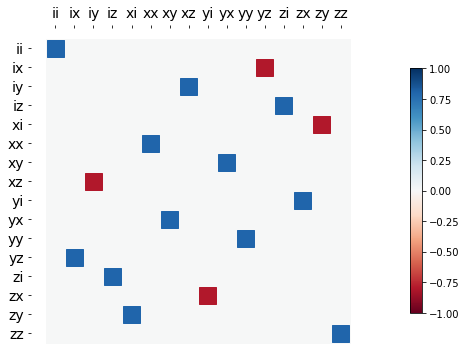

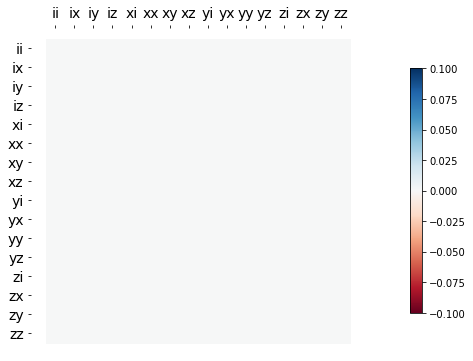

In [8]:
R_ideal = T.get_R_iswap_ideal()
#R_ideal = T.get_R_2iswap_phi(1.57)
R_ideal_re = real (R_ideal)
R_ideal_im = imag (R_ideal)
xlabels = ['ii','ix','iy','iz','xi','xx','xy','xz','yi','yx','yy','yz','zi','zx','zy','zz']
ylabels = xlabels
fig,ax = hinton (R_ideal_re, xlabels = xlabels, ylabels = ylabels, title = (r'$Re\ R$'))
hinton (R_ideal_im, xlabels = xlabels, ylabels = ylabels, title = (r'$Im\ R$'))
#fig.savefig ('19.10.2021 QPT ideal i swap.png')

#def fidelity (phi):
#    return -T.Fidelity(R_tomo, T.get_R_2iswap_phi(phi))
#minimize (fidelity, 0.2)

In [9]:
fidelity =T.Fidelity(R_tomo, R_ideal)
print('fidelity =', fidelity)

fidelity = (0.9943981150448136+4.5115444199745335e-21j)


/tmp/ipykernel_1333491/3514991098.py:3: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
  delta_R_re = real (delta_R)
/tmp/ipykernel_1333491/3514991098.py:4: DeprecationWarning: scipy.imag is deprecated and will be removed in SciPy 2.0.0, use numpy.imag instead
  delta_R_im = imag (delta_R)


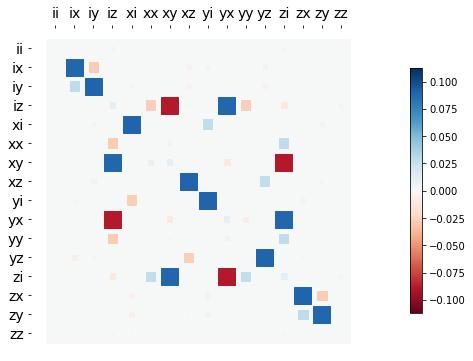

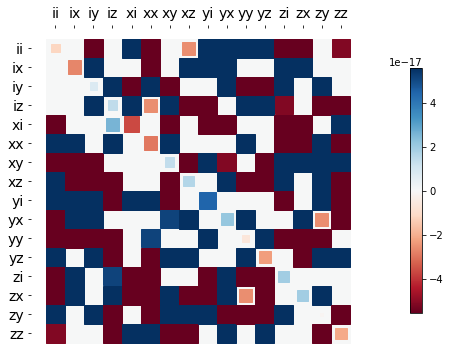

In [35]:
delta_R = R_tomo - R_ideal

delta_R_re = real (delta_R)
delta_R_im = imag (delta_R)
xlabels = ['ii','ix','iy','iz','xi','xx','xy','xz','yi','yx','yy','yz','zi','zx','zy','zz']
ylabels = xlabels
fig, ax = hinton (delta_R_re, xlabels = xlabels, ylabels = ylabels, title = (r'$Re\ R$'))
hinton (delta_R_im, xlabels = xlabels, ylabels = ylabels, title = (r'$Im\ R$'))
fig.savefig ('25.11.2021/ QPT i swap with right phases 3 level operator difference between ideal iswap and our gate.png')

In [11]:
f_partial = partial(Tomography.likelihood_R, T)
best = minimize (f_partial,x0 = (1.0,0,0,0,0),args = (R_tomo), method = 'BFGS')

/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/Tomography.py:889: ComplexWarning: Casting complex values to real discards the imaginary part
  R_gate[i][j]=1/4*np.trace(dot(pauli[i], images[j]))


In [12]:
theta = best.x[0]
phi = best.x[1]
delta_off = best.x[2]
delta_plus = best.x[3]
delta_minus = best.x[4]
print ('theta =', theta, 'phi =', phi, 'delta_off =', delta_off, 'delta_plus =', delta_plus, '\ndelta_minus =', delta_minus  )

theta = 1.4533322124288484 phi = 0.0008895456496619829 delta_off = 0.0023909681220987996 delta_plus = 0.003968729542941502 
delta_minus = 0.3058891861296503


In [13]:
best.x

array([1.45333221e+00, 8.89545650e-04, 2.39096812e-03, 3.96872954e-03,
       3.05889186e-01])

In [14]:
best.fun

0.016237851050536267

(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

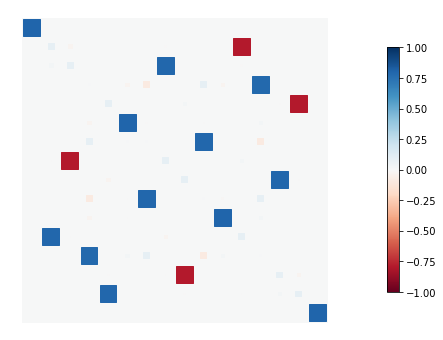

In [15]:
hinton(T.R_fsim_like(best.x[0],best.x[1], best.x[2], best.x[3], best.x[4]))

## Test time of execution functions in optimizer

In [37]:
density_matrix_after_gate = []
find_rho_partial = partial(Tomography._find_rho_iswap,T,3)   
density_matrix_after_gate = p_imap(find_rho_partial, T._results_iswap ,num_cpus=20)
density_matrix_after_gate_full = []
#for ind in range (len(density_matrix_after_gate)):
           #density_matrix_after_gate_full.append(density_matrix_after_gate[ind].full())           
for dm in density_matrix_after_gate:
    density_matrix_after_gate_full.append(dm.full())


AttributeError: 'Tomography' object has no attribute '_results_iswap'

### Likelihood calculation time test

In [36]:


x1 = random.rand(256)
start = time.time()
for i in range (1000):
    lh = T._likelihood_iswap(x1,density_matrix_after_gate_full)
finish = time.time()
print ((finish - start)/1000)

NameError: name 'density_matrix_after_gate_full' is not defined

## Minimizer time test

In [38]:
x0 = random.rand(256)
max_iter = 200
start = time.time()
for n in tqdm_notebook(range(1), desc='Tomography iswap_operator: Likelihood minimization', ncols=700):
            new = minimize (T._likelihood_iswap, x0, args = (density_matrix_after_gate_full,), 
                                     tol= 1e-09, options = {'gtol': 1e-05,'maxiter': max_iter})
            if (n==0):
                best = new
            elif (new.fun < best.fun):
                best = new           
            x0 =best.x + 0.1*(random.rand(256)*2 - 1)
            print (best.fun, new.fun)
finish = time.time()
print (finish - start, 's for', max_iter, ' iterations')
print ('error is', best.fun)

/tmp/ipykernel_1333491/1233345171.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(1), desc='Tomography iswap_operator: Likelihood minimization', ncols=700):


Tomography iswap_operator: Likelihood minimization:   0%|                                                     …

NameError: name 'density_matrix_after_gate_full' is not defined

In [ ]:
chi_tomo = Tomography.x_to_chi(best.x)
labels = [['i','x','y','z']]*2
qpt_plot_combined(chi_tomo, labels, figsize = (14,14))

## System spectrum

<IPython.core.display.Javascript object>


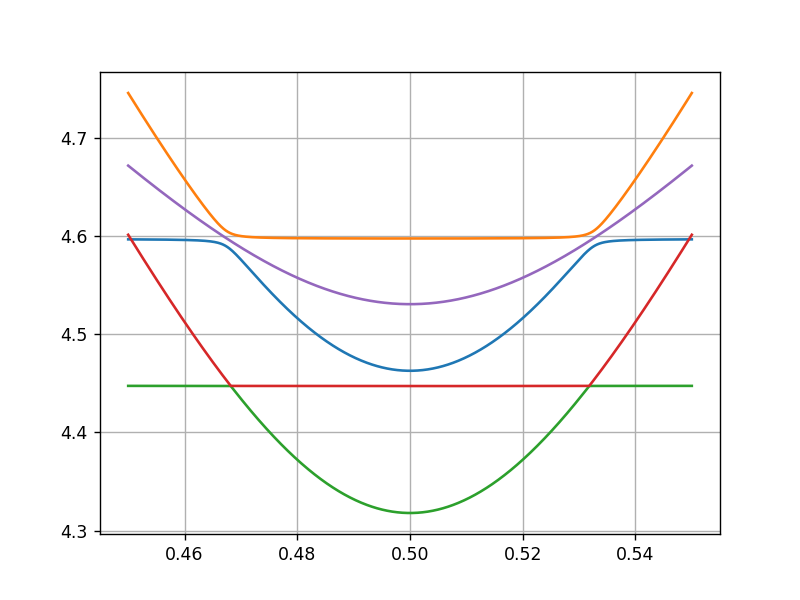

/tmp/ipykernel_1084974/755709939.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace (0.45,0.55,1000)
/tmp/ipykernel_1084974/755709939.py:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2


Energy levels calculation:   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
figure()
phi1s = linspace (0.45,0.55,1000)
phi2s = ones_like(phi1s)*1/2
dts.plot_spectrum(phi1s,phi2s)

<IPython.core.display.Javascript object>


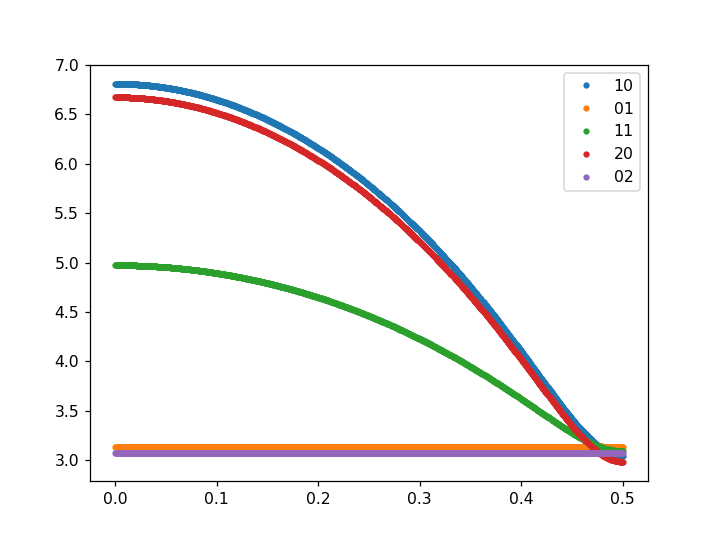

/tmp/ipykernel_1068018/579322283.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace (0, 0.5, 1000)
/tmp/ipykernel_1068018/579322283.py:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2


In [4]:
figure()
phi1s = linspace (0, 0.5, 1000)
phi2s = ones_like(phi1s)*1/2
freq10=[]
freq01=[]
freq11=[]
freq02=[]
freq20=[]

for ind in range(len(phi1s)):
    phi1 = phi1s[ind]
    phi2 = phi2s[ind]
    freq10.append((dts.e_state(phi1,phi2,1,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/pi)
    freq01.append((dts.e_state(phi1,phi2,2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/pi)
    freq11.append((dts.ee_state(phi1,phi2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)
    freq20.append((dts.f_state(phi1,phi2,1,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)
    freq02.append((dts.f_state(phi1,phi2,2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)
plot(phi1s, freq10, '.', label = '10')
plot(phi1s, freq01, '.', label = '01')
plot(phi1s, freq11, '.', label = '11')
plot(phi1s, freq20, '.', label = '20')
plot(phi1s, freq02, '.',label = '02')
legend() 

### Z-gate frequencies calculation

In [ ]:
E0 = dts.gg_state(0, 1/2, True)[1]
E10 = dts.e_state(0, 1/2, 1, True)[1]
E01 = dts.e_state(0, 1/2, 2, True)[1]
print ((E10-E0)/2/pi)
omega1_0 = dts.e_state(0, 1/2, 1, True)[1] - dts.gg_state(0, 1/2, True)[1]
omega2_0 = dts.e_state(0, 1/2, 2, True)[1] - dts.gg_state(0, 1/2, True)[1]
omega1_shifted = dts.e_state(params["phiz_offset"], 1/2, 1, True)[1] - dts.gg_state(params["phiz_offset"], 1/2, True)[1]
omega2_shifted = dts.e_state(0, 1/2 + params["phi2z_offset"], 2, True)[1] - \
dts.gg_state(0, 1/2 + params["phi2z_offset"], True)[1]
print (omega1_0, omega2_0)
print (omega1_shifted, omega2_shifted)
delta_omega1 = omega1_shifted - omega1_0
delta_omega2 = omega2_shifted - omega2_0
print (delta_omega1, delta_omega2)


In [ ]:
omega2_2-omega1_2